In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import wandb
import random

In [ ]:
random.seed(42)
np.random.seed(42)

# 1. Data

In [ ]:
# Load data
train = pd.read_csv('/content/drive/MyDrive/BDML-2024/P-Set2/data/imputed_no_missings/train_ready.csv')
test = pd.read_csv('/content/drive/MyDrive/BDML-2024/P-Set2/data/imputed_no_missings/test_ready.csv')

train.shape, test.shape

((164960, 49), (66168, 42))

In [ ]:
train.columns

Index(['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'Nper', 'Npersug',
       'Ingtotug', 'Ingtotugarr', 'Ingpcug', 'Li', 'Lp', 'Pobre', 'Indigente',
       'Npobres', 'Nindigentes', 'Fex_c', 'Depto', 'Fex_dpto',
       'mean_age_household', 'has_social_program', 'educ_attainment',
       'P6240_someone_works', 'P6240_unemployment_rate',
       'P6240_main_household_activity', 'P6240_activity_diversity',
       'has_food_subsidy', 'has_transport_subsidy', 'has_family_subsidy',
       'has_school_subsidy', 'total_subsidies', 'has_pension_contributor',
       'has_pensioner', 'prop_pension_contributors', 'prop_pensioners',
       'pension_status', 'household_size', 'dependency_ratio',
       'is_female_headed', 'has_health_insurance', 'main_insurance_type',
       'insurance_coverage_rate', 'num_individuals', 'num_under_18',
       'num_over_65', 'has_over_65', 'has_university_education',
       'receives_food_payment'],
      dtype='object')

In [ ]:
# are there missing values?
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [ ]:
categorical_features = [
    'Dominio', 'P6240_someone_works', 'pension_status', 'is_female_headed', 'has_health_insurance',
    'Clase', 'has_social_program', 'educ_attainment', 'P6240_main_household_activity',
    'has_food_subsidy', 'has_transport_subsidy', 'has_family_subsidy',
    'has_school_subsidy', 'has_pension_contributor', 'has_pensioner',
    'main_insurance_type', 'has_university_education', 'receives_food_payment'
]

numeric_features = [
    'P5000', 'P5010', 'P5090', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto',
    'mean_age_household', 'P6240_unemployment_rate', 'P6240_activity_diversity',
    'total_subsidies', 'prop_pension_contributors', 'prop_pensioners', 'household_size',
    'dependency_ratio', 'insurance_coverage_rate', 'num_individuals', 'num_under_18',
    'num_over_65', 'has_over_65'
]

In [ ]:
train.shape

(164960, 43)

# 2. Base Model Training
(Untunned)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import numpy as np
import pandas as pd

class XGBoostWrapper:
    def __init__(self, booster):
        self.booster = booster

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return (self.booster.predict(dtest) > 0.5).astype(int)


In [ ]:
def train_base_model(features, labels, model_params, categorical_features, numeric_features):
    # Identify which categorical and numeric features are present in the data
    available_cat_features = [f for f in categorical_features if f in features.columns]
    available_num_features = [f for f in numeric_features if f in features.columns]

    # One-hot encode categorical features
    features_encoded = pd.get_dummies(features, columns=available_cat_features, drop_first=True)

    # Select numeric features
    features_numeric = features_encoded[available_num_features]

    print(f"Selected {len(available_num_features)} numeric features: {available_num_features}")
    print(f"Selected {len(available_cat_features)} categorical features: {available_cat_features}")

    # Set up cross-validation
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Cross-validation loop
    fold_scores = []
    best_overall_f1 = 0
    best_overall_model = None
    best_overall_scaler = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(features_encoded, labels), 1):
        print(f"\nFold {fold}")

        # Split data
        X_train, X_val = features_encoded.iloc[train_idx], features_encoded.iloc[val_idx]
        y_train, y_val = labels.iloc[train_idx], labels.iloc[val_idx]

        # Scale numeric features
        scaler = StandardScaler()
        X_train_numeric = X_train[available_num_features]
        X_val_numeric = X_val[available_num_features]
        X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
        X_val_numeric_scaled = scaler.transform(X_val_numeric)

        # Replace numeric columns with scaled versions
        X_train_scaled = X_train.copy()
        X_val_scaled = X_val.copy()
        X_train_scaled[available_num_features] = X_train_numeric_scaled
        X_val_scaled[available_num_features] = X_val_numeric_scaled

        print("Original training set shape:", np.bincount(y_train))

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
        print("Resampled training set shape:", np.bincount(y_train_resampled))

        # Calculate class weights
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
        class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))
        print(f"Class weights: {class_weight_dict}")

        # Convert data to DMatrix format
        dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
        dval = xgb.DMatrix(X_val_scaled, label=y_val)

        # Set up early stopping
        evallist = [(dval, 'eval'), (dtrain, 'train')]

        # Update model_params with scale_pos_weight
        model_params_updated = model_params.copy()
        model_params_updated['scale_pos_weight'] = class_weight_dict[1] / class_weight_dict[0]

        # Train the model
        bst = xgb.train(model_params_updated, dtrain, num_boost_round=1000,
                        evals=evallist, early_stopping_rounds=10, verbose_eval=False)

        # Evaluate
        val_preds = (bst.predict(dval) > 0.5).astype(int)
        val_f1 = f1_score(y_val, val_preds)
        fold_scores.append(val_f1)
        print(f"Validation F1 for Fold {fold}: {val_f1:.4f}")
        print(f"\nClassification Report for Fold {fold}:")
        print(classification_report(y_val, val_preds))

        # Save the best overall model
        if val_f1 > best_overall_f1:
            best_overall_f1 = val_f1
            best_overall_model = bst
            best_overall_scaler = scaler

    # Calculate and print average F1 score across folds
    average_f1 = np.mean(fold_scores)
    print(f"\nAverage F1 Score across {n_splits} folds: {average_f1:.4f}")
    print(f"F1 Scores for each fold: {fold_scores}")

     # Print feature importance
    feature_importance = best_overall_model.get_score(importance_type='weight')
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    print("\nFeature Importance:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance}")

    return best_overall_model, best_overall_scaler, best_overall_f1, features_encoded.columns


In [ ]:
model_params = {
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']

base_model, base_scaler, best_f1, feature_columns = train_base_model(features, labels, model_params, categorical_features, numeric_features)
print(f"Best Overall Validation F1 Score: {best_f1:.4f}")

Selected 23 numeric features: ['P5000', 'P5010', 'P5090', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto', 'mean_age_household', 'P6240_unemployment_rate', 'P6240_activity_diversity', 'total_subsidies', 'prop_pension_contributors', 'prop_pensioners', 'household_size', 'dependency_ratio', 'insurance_coverage_rate', 'num_individuals', 'num_under_18', 'num_over_65', 'has_over_65']
Selected 18 categorical features: ['Dominio', 'P6240_someone_works', 'pension_status', 'is_female_headed', 'has_health_insurance', 'Clase', 'has_social_program', 'educ_attainment', 'P6240_main_household_activity', 'has_food_subsidy', 'has_transport_subsidy', 'has_family_subsidy', 'has_school_subsidy', 'has_pension_contributor', 'has_pensioner', 'main_insurance_type', 'has_university_education', 'receives_food_payment']

Fold 1
Original training set shape: [87957 22016]
Resampled training set shape: [87957 87957]
Class weights: {0: 1.0, 1: 1.0}
Validation F1 for Fold 1: 1.0000

Classification Report f

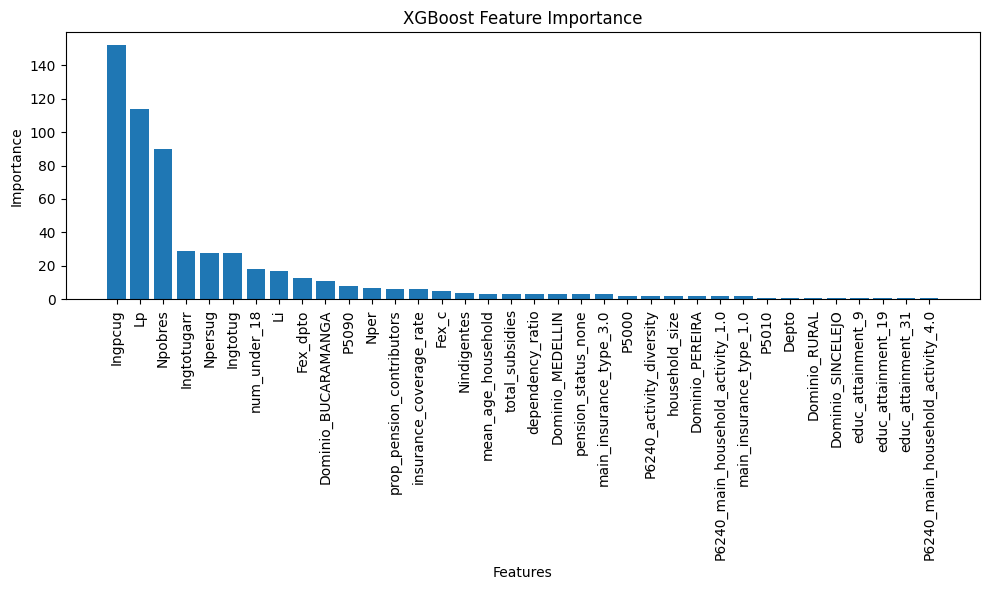

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_columns):
    importance = model.get_score(importance_type='weight')
    importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features, values = zip(*importance)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(features)), values)
    plt.xticks(range(len(features)), features, rotation=90)
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importance(base_model, feature_columns)

In [ ]:
####

In [ ]:
class XGBoostWrapper:
    def __init__(self, booster):
        self.booster = booster

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return (self.booster.predict(dtest) > 0.5).astype(int)

In [ ]:
def train_base_model(features, labels, model_params, categorical_features, numeric_features):
    # Identify available features
    available_cat_features = [f for f in categorical_features if f in features.columns]
    available_num_features = [f for f in numeric_features if f in features.columns]

    # One-hot encode categorical features
    features_encoded = pd.get_dummies(features, columns=available_cat_features, drop_first=True)
    X = features_encoded
    y = labels

    print(f"Selected {len(available_num_features)} numeric features: {available_num_features}")
    print(f"Selected {len(available_cat_features)} categorical features: {available_cat_features}")

    # Stratified K-Fold Cross-Validation
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=model_params.get('random_state', 42))

    fold_scores = []
    best_overall_f1 = 0
    best_overall_model = None
    best_overall_scaler = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}")

        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Scale numeric features
        scaler = StandardScaler()
        num_columns_in_X = [col for col in X.columns if col in available_num_features]
        X_train_num = X_train[num_columns_in_X]
        X_val_num = X_val[num_columns_in_X]
        X_train_num_scaled = scaler.fit_transform(X_train_num)
        X_val_num_scaled = scaler.transform(X_val_num)

        # Replace numeric columns with scaled versions
        X_train_scaled = X_train.copy()
        X_val_scaled = X_val.copy()
        X_train_scaled[num_columns_in_X] = X_train_num_scaled
        X_val_scaled[num_columns_in_X] = X_val_num_scaled

        print("Original training set shape:", np.bincount(y_train))

        # Apply SMOTE
        smote = SMOTE(random_state=model_params.get('random_state', 42))
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
        print("Resampled training set shape:", np.bincount(y_train_resampled))

        # Extract n_estimators and remove it from model_params
        model_params = model_params.copy()
        n_estimators = model_params.pop('n_estimators', 1000)

        # Prepare DMatrix
        dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
        dval = xgb.DMatrix(X_val_scaled, label=y_val)

        # Set up early stopping
        evallist = [(dval, 'eval'), (dtrain, 'train')]

        # Train the model
        bst = xgb.train(
            model_params,
            dtrain,
            num_boost_round=n_estimators,
            evals=[(dval, 'eval'), (dtrain, 'train')],
            early_stopping_rounds=10,
            verbose_eval=False
        )

        # Evaluate
        val_preds = (bst.predict(dval) > 0.5).astype(int)
        val_f1 = f1_score(y_val, val_preds)
        fold_scores.append(val_f1)
        print(f"Validation F1 for Fold {fold}: {val_f1:.4f}")
        print(f"\nClassification Report for Fold {fold}:")
        print(classification_report(y_val, val_preds))

        # Save the best overall model
        if val_f1 > best_overall_f1:
            best_overall_f1 = val_f1
            best_overall_model = bst
            best_overall_scaler = scaler

    # Average F1 Score
    average_f1 = np.mean(fold_scores)
    print(f"\nAverage F1 Score across {n_splits} folds: {average_f1:.4f}")
    print(f"F1 Scores for each fold: {fold_scores}")

    return best_overall_model, best_overall_scaler, best_overall_f1, X.columns

In [ ]:
model_params = {
    'max_depth': 6,
    'eta': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42,
    'n_estimators': 500
}

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']

base_model, base_scaler, best_f1, feature_columns = train_base_model(
    features, labels, model_params, categorical_features, numeric_features
)
print(f"Best Overall Validation F1 Score: {best_f1:.4f}")

Selected 23 numeric features: ['P5000', 'P5010', 'P5090', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto', 'mean_age_household', 'P6240_unemployment_rate', 'P6240_activity_diversity', 'total_subsidies', 'prop_pension_contributors', 'prop_pensioners', 'household_size', 'dependency_ratio', 'insurance_coverage_rate', 'num_individuals', 'num_under_18', 'num_over_65', 'has_over_65']
Selected 18 categorical features: ['Dominio', 'P6240_someone_works', 'pension_status', 'is_female_headed', 'has_health_insurance', 'Clase', 'has_social_program', 'educ_attainment', 'P6240_main_household_activity', 'has_food_subsidy', 'has_transport_subsidy', 'has_family_subsidy', 'has_school_subsidy', 'has_pension_contributor', 'has_pensioner', 'main_insurance_type', 'has_university_education', 'receives_food_payment']

Fold 1
Original training set shape: [87957 22016]
Resampled training set shape: [87957 87957]
Validation F1 for Fold 1: 0.6560

Classification Report for Fold 1:
              precisi

# Tuning – Weights & Biases

In [ ]:
def wandb_tuning(features, labels, sweep_config, project_name, categorical_features, numeric_features):
    def train():
        with wandb.init() as run:
            config = wandb.config

            # Identify available features
            available_cat_features = [f for f in categorical_features if f in features.columns]
            available_num_features = [f for f in numeric_features if f in features.columns]

            # One-hot encode categorical features
            features_encoded = pd.get_dummies(features, columns=available_cat_features, drop_first=True)
            X = features_encoded
            y = labels

            # Split data
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=0.2, random_state=config.get('random_state', 42), stratify=y
            )

            # Scale numeric features
            scaler = StandardScaler()
            num_columns_in_X = [col for col in X.columns if col in available_num_features]
            X_train_num = X_train[num_columns_in_X]
            X_val_num = X_val[num_columns_in_X]
            X_train_num_scaled = scaler.fit_transform(X_train_num)
            X_val_num_scaled = scaler.transform(X_val_num)

            # Replace numeric columns with scaled versions
            X_train_scaled = X_train.copy()
            X_val_scaled = X_val.copy()
            X_train_scaled[num_columns_in_X] = X_train_num_scaled
            X_val_scaled[num_columns_in_X] = X_val_num_scaled

            # Apply SMOTE
            smote = SMOTE(random_state=config.get('random_state', 42))
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

            # Extract n_estimators and remove it from best_params
            best_params = best_params.copy()
            n_estimators = best_params.pop('n_estimators', 1000)

            # Prepare DMatrix
            dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
            dval = xgb.DMatrix(X_val_scaled, label=y_val)

            # Define model parameters from wandb.config
            model_params = {
                'max_depth': int(config.max_depth),
                'eta': config.learning_rate,
                'subsample': config.subsample,
                'colsample_bytree': config.colsample_bytree,
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'seed': config.get('random_state', 42)
            }

            # Train the model
            bst = xgb.train(
                best_params,
                dtrain,
                num_boost_round=n_estimators,
                evals=[(dval, 'eval'), (dtrain, 'train')],
                early_stopping_rounds=10,
                verbose_eval=False)

            return bst, scaler, X_scaled.columns

            # Evaluate
            val_preds = (bst.predict(dval) > 0.5).astype(int)
            val_f1 = f1_score(y_val, val_preds)
            print(f"Validation F1: {val_f1:.4f}")

            # Log metrics
            wandb.log({'val_f1': val_f1})

    # Initialize the sweep
    sweep_id = wandb.sweep(sweep_config, project=project_name)
    wandb.agent(sweep_id, function=train, count=20)

# Define sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_f1', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'min': 0.01, 'max': 0.3},
        'n_estimators': {'min': 100, 'max': 1000},
        'max_depth': {'min': 3, 'max': 10},
        'subsample': {'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'min': 0.5, 'max': 1.0},
        'random_state': {'value': 42}
    }
}

# Train Final Model & Predictions

In [ ]:
def train_final_model(features, labels, best_params, categorical_features, numeric_features):
    # Identify available features
    available_cat_features = [f for f in categorical_features if f in features.columns]
    available_num_features = [f for f in numeric_features if f in features.columns]

    # One-hot encode categorical features
    features_encoded = pd.get_dummies(features, columns=available_cat_features, drop_first=True)
    X = features_encoded
    y = labels

    # Scale numeric features
    scaler = StandardScaler()
    num_columns_in_X = [col for col in X.columns if col in available_num_features]
    X_num = X[num_columns_in_X]
    X_num_scaled = scaler.fit_transform(X_num)

    # Replace numeric columns with scaled versions
    X_scaled = X.copy()
    X_scaled[num_columns_in_X] = X_num_scaled

    # Apply SMOTE
    smote = SMOTE(random_state=best_params.get('random_state', 42))
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Prepare DMatrix
    dtrain = xgb.DMatrix(X_resampled, label=y_resampled)

    # Define model parameters
    model_params = best_params.copy()
    model_params['objective'] = 'binary:logistic'
    model_params['eval_metric'] = 'logloss'
    model_params['seed'] = best_params.get('random_state', 42)

    num_boost_round = model_params.pop('n_estimators', 1000)

    # Train the model
    bst = xgb.train(model_params, dtrain, num_boost_round=num_boost_round)

    return bst, scaler, X_scaled.columns

In [ ]:
def make_predictions(model, test_data, scaler, feature_columns, numeric_features, categorical_features):
    # Identify available features
    available_cat_features = [f for f in categorical_features if f in test_data.columns]
    available_num_features = [f for f in numeric_features if f in test_data.columns]

    # One-hot encode categorical features
    test_encoded = pd.get_dummies(test_data, columns=available_cat_features, drop_first=True)

    # Align test data with training data
    for col in feature_columns:
        if col not in test_encoded.columns:
            test_encoded[col] = 0
    test_encoded = test_encoded[feature_columns]

    # Scale numeric features
    num_columns_in_test = [col for col in test_encoded.columns if col in available_num_features]
    test_num = test_encoded[num_columns_in_test]
    test_num_scaled = scaler.transform(test_num)

    # Replace numeric columns with scaled versions
    test_scaled = test_encoded.copy()
    test_scaled[num_columns_in_test] = test_num_scaled

    # Prepare DMatrix
    dtest = xgb.DMatrix(test_scaled)

    # Make predictions
    preds = (model.predict(dtest) > 0.5).astype(int)

    return preds

# best_params obtained from tuning -- [skilled-sweep-2]
best_params = {
    'max_depth': 3,
    'eta': 0.15224056012631346,
    'subsample': 0.7806214265012723,
    'colsample_bytree': 0.8737607635364437,
    'random_state': 42,
    'n_estimators': 253
}

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']

final_model, final_scaler, feature_columns = train_final_model(
    features, labels, best_params, categorical_features, numeric_features)

# Make predictions on test set
test_features = test.drop(['id'], axis=1)
predictions = make_predictions(
    final_model, test_features, final_scaler, feature_columns, numeric_features, categorical_features)

# Kaggle Submission

In [ ]:
def set_kaggle_credentials():
    username = input("Enter your Kaggle username: ")
    key = getpass("Enter your Kaggle API key: ")
    os.environ['KAGGLE_USERNAME'] = username
    os.environ['KAGGLE_KEY'] = key
    print("Kaggle credentials set as environment variables.")

In [ ]:
# Create Submission File
submission_dir = '/content/drive/MyDrive/BDML-2024/P-Set2/submissions/XGBoost/'
os.makedirs(submission_dir, exist_ok=True)

def create_submission(test_data, predictions, directory, filename='XGBoost_final.csv'):
    # Construct full file path
    filepath = os.path.join(directory, filename)

    # Create the submission DataFrame and save it to the specified path
    submission = pd.DataFrame({'id': test_data['id'], 'pobre': predictions})
    submission.to_csv(filepath, index=False)
    print(f"Submission saved to {filepath}")
    return filepath  # Return the full file path

In [ ]:
# 3. Submit to Kaggle
def submit_to_kaggle(file_path, message):
    competition = "uniandes-bdml-2024-20-ps-2"
    command = f"kaggle competitions submit -c {competition} -f {file_path} -m \"{message}\""
    print(f"Submitting to Kaggle with command: {command}")
    os.system(command)

In [ ]:
# 4. Main Execution Flow
submission_filename = 'XGBoost_final.csv'
submission_file_path = create_submission(test, predictions, submission_dir, submission_filename)
print(f"Submission file path: {submission_file_path}")

# Set credentials and submit to Kaggle
set_kaggle_credentials()
submit_to_kaggle(submission_file_path, "XGBoost model with tuned hyperparameters version FINAL")

print("Submission process completed!")

Submission saved to /content/drive/MyDrive/BDML-2024/P-Set2/submissions/XGBoost/XGBoost_final.csv
Submission file path: /content/drive/MyDrive/BDML-2024/P-Set2/submissions/XGBoost/XGBoost_final.csv
Enter your Kaggle username: edmundoariasdeabreu
Enter your Kaggle API key: ··········
Kaggle credentials set as environment variables.
Submitting to Kaggle with command: kaggle competitions submit -c uniandes-bdml-2024-20-ps-2 -f /content/drive/MyDrive/BDML-2024/P-Set2/submissions/XGBoost/XGBoost_final.csv -m "XGBoost model with tuned hyperparameters version FINAL"
Submission process completed!


In [ ]:
####

In [ ]:
# Helper function for making predictions
def make_predictions(model, features):
    return model.predict(features)

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'average_val_f1', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'min': 0.01, 'max': 0.3},
        'n_estimators': {'min': 100, 'max': 1000},
        'max_depth': {'min': 3, 'max': 10},
        'subsample': {'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'min': 0.5, 'max': 1.0},
    }
}

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']
wandb_tuning(features, labels, sweep_config, "poverty-prediction-xgboost")


wandb.login(key="********")

TypeError: wandb_tuning() missing 2 required positional arguments: 'categorical_features' and 'numeric_features'

# 3. Tuning – Weights & Biases

In [ ]:
from getpass import getpass

In [ ]:
def wandb_tuning(features, labels, sweep_config, project_name):
    def train():
        with wandb.init() as run:
            config = wandb.config

            numeric_columns = features.select_dtypes(include=['int64', 'float64']).columns
            features_numeric = features[numeric_columns].values

            print(f"Selected {len(numeric_columns)} numeric features: {numeric_columns.tolist()}")

            # Set up cross-validation
            n_splits = 3
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

            # Cross-validation loop
            fold_scores = []

            for fold, (train_idx, val_idx) in enumerate(skf.split(features_numeric, labels), 1):
                print(f"\nFold {fold}")

                # Split data
                X_train, X_val = features_numeric[train_idx], features_numeric[val_idx]
                y_train, y_val = labels.iloc[train_idx].values, labels.iloc[val_idx].values

                # Scale features
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)

                print("Original training set shape:", np.bincount(y_train))

                # Calculate class weights
                class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
                class_weight_dict = dict(zip(np.unique(y_train), class_weights))
                print(f"Class weights: {class_weight_dict}")

                # Convert data to DMatrix format
                dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
                dval = xgb.DMatrix(X_val_scaled, label=y_val)

                # Set up early stopping
                evallist = [(dval, 'eval'), (dtrain, 'train')]

                # Update model_params with wandb config
                model_params = {
                    'max_depth': config.max_depth,
                    'eta': config.learning_rate,
                    'subsample': config.subsample,
                    'colsample_bytree': config.colsample_bytree,
                    'objective': 'binary:logistic',
                    'eval_metric': 'logloss',
                    'seed': 42,
                    'scale_pos_weight': class_weight_dict[1] / class_weight_dict[0]
                }

                # Train the model
                bst = xgb.train(model_params, dtrain, num_boost_round=config.n_estimators,
                                evals=evallist, early_stopping_rounds=10, verbose_eval=False)

                # Create a wrapper for the trained booster
                model = XGBoostWrapper(bst)

                # Evaluate
                val_preds = model.predict(X_val_scaled)
                val_f1 = f1_score(y_val, val_preds)
                fold_scores.append(val_f1)

                print(f"Best Validation F1 for Fold {fold}: {val_f1:.4f}")

                print(f"\nClassification Report for Fold {fold}:")
                print(classification_report(y_val, val_preds))

                # Log metrics for this fold
                wandb.log({
                    f'fold_{fold}_val_f1': val_f1,
                })

            # Calculate and log average F1 score across folds
            average_f1 = np.mean(fold_scores)
            wandb.log({
                'average_val_f1': average_f1,
                'fold_scores': fold_scores
            })

            print(f"\nAverage F1 Score across {n_splits} folds: {average_f1:.4f}")
            print(f"F1 Scores for each fold: {fold_scores}")

    sweep_id = wandb.sweep(sweep_config, project=project_name)
    wandb.agent(sweep_id, function=train, count=20)  # set to preference

In [ ]:
# Helper function for making predictions
def make_predictions(model, features):
    return model.predict(features)

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'average_val_f1', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'min': 0.01, 'max': 0.3},
        'n_estimators': {'min': 100, 'max': 1000},
        'max_depth': {'min': 3, 'max': 10},
        'subsample': {'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'min': 0.5, 'max': 1.0},
    }
}

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']
wandb_tuning(features, labels, sweep_config, "poverty-prediction-xgboost")


wandb.login(key="*****")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: ru0nqwt6
Sweep URL: https://wandb.ai/edmundo-research/poverty-prediction-xgboost/sweeps/ru0nqwt6


wandb: Agent Starting Run: 2zo4v6zr with config:
wandb: 	colsample_bytree: 0.9348407059207408
wandb: 	learning_rate: 0.2601906110128546
wandb: 	max_depth: 7
wandb: 	n_estimators: 486
wandb: 	subsample: 0.7235992224586553
wandb: Currently logged in as: e-ariasd (edmundo-research). Use `wandb login --relogin` to force relogin


Selected 36 numeric features: ['Clase', 'P5000', 'P5010', 'P5090', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto', 'mean_age_household', 'has_social_program', 'educ_attainment', 'P6240_unemployment_rate', 'P6240_main_household_activity', 'P6240_activity_diversity', 'has_food_subsidy', 'has_transport_subsidy', 'has_family_subsidy', 'has_school_subsidy', 'total_subsidies', 'has_pension_contributor', 'has_pensioner', 'prop_pension_contributors', 'prop_pensioners', 'household_size', 'dependency_ratio', 'main_insurance_type', 'insurance_coverage_rate', 'num_individuals', 'num_under_18', 'num_over_65', 'has_over_65', 'has_university_education', 'receives_food_payment']

Fold 1
Original training set shape: [87957 22016]
Class weights: {0: 0.6251520629398456, 1: 2.497569949127907}


wandb: Ctrl + C detected. Stopping sweep.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# 4. Final Training & Prediction

In [ ]:
def train_final_model(features, labels, best_params):
    numeric_columns = features.select_dtypes(include=['int64', 'float64']).columns
    features_numeric = features[numeric_columns].values

    print(f"Selected {len(numeric_columns)} numeric features: {numeric_columns.tolist()}")

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_numeric, labels, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    print("Original training set shape:", np.bincount(y_train))

    # Calculate class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    print(f"Class weights: {class_weight_dict}")

    # Convert data to DMatrix format
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dval = xgb.DMatrix(X_val_scaled, label=y_val)

    # Set up early stopping
    evallist = [(dval, 'eval'), (dtrain, 'train')]

    # Update best_params with scale_pos_weight and remove n_estimators
    best_params_updated = best_params.copy()
    best_params_updated['scale_pos_weight'] = class_weight_dict[1] / class_weight_dict[0]
    n_estimators = best_params_updated.pop('n_estimators', 1000)  # Default to 1000 if not provided

    # Train the final model
    print("Training final model with best parameters:")
    print(best_params_updated)
    bst = xgb.train(best_params_updated, dtrain, num_boost_round=n_estimators,
                    evals=evallist, early_stopping_rounds=10, verbose_eval=100)

    # Create a wrapper for the trained booster
    model = XGBoostWrapper(bst)

    # Evaluate on validation set
    val_preds = model.predict(X_val_scaled)
    val_f1 = f1_score(y_val, val_preds)
    print(f"\nFinal Validation F1 Score: {val_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, val_preds))

    return model, scaler

In [ ]:
def make_predictions(model, test_data, scaler):
    numeric_columns = test_data.select_dtypes(include=['int64', 'float64']).columns
    test_data_numeric = test_data[numeric_columns].values

    test_scaled = scaler.transform(test_data_numeric)
    predictions = model.predict(test_scaled)
    return predictions

# usage –– get hyperparameters from wandb tuning (treasured-sweep-17)
best_params = {
    'max_depth': 9,
    'eta': 0.08033620527180446,
    'subsample': 0.6432694972867776,
    'colsample_bytree': 0.5509301191523459,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_estimators': 210,
    'seed': 42
}

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']

final_model, final_scaler = train_final_model(features, labels, best_params)

# Make predictions on test set
test_features = test.drop('id', axis=1)
predictions = make_predictions(final_model, test_features, final_scaler)

print("Shape of predictions:", predictions.shape)
print("First few predictions:", predictions[:10])

# Optional: Save the model and scaler for future use
import joblib

joblib.dump(final_model, 'final_xgboost_model.joblib')
joblib.dump(final_scaler, 'final_scaler.joblib')
print("Model and scaler saved.")

# Optional: Feature importance
feature_importance = final_model.booster.get_score(importance_type='gain')
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 most important features:")
for feature, importance in sorted_importance[:10]:
    print(f"{feature}: {importance}")

Selected 26 numeric features: ['Clase', 'P5000', 'P5010', 'P5090', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto', 'mean_age_household', 'has_social_program', 'educ_attainment', 'P6240_unemployment_rate', 'P6240_main_household_activity', 'P6240_activity_diversity', 'has_food_subsidy', 'has_transport_subsidy', 'has_family_subsidy', 'has_school_subsidy', 'total_subsidies', 'has_pension_contributor', 'has_pensioner', 'prop_pension_contributors', 'prop_pensioners']
Original training set shape: [93014 21160]
Class weights: {0: 0.613746317758617, 1: 2.6978733459357276}
Training final model with best parameters:
{'max_depth': 9, 'eta': 0.08033620527180446, 'subsample': 0.6432694972867776, 'colsample_bytree': 0.5509301191523459, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42, 'scale_pos_weight': 4.395746691871455}
[0]	eval-logloss:0.65860	train-logloss:0.65830
[100]	eval-logloss:0.35701	train-logloss:0.31155
[200]	eval-logloss:0.34452	train-logloss:0.26593
[2

In [ ]:
### Adjusted class weights + SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import numpy as np
import joblib

def train_final_model(features, labels, best_params):
    numeric_columns = features.select_dtypes(include=['int64', 'float64']).columns
    features_numeric = features[numeric_columns].values
    print(f"Selected {len(numeric_columns)} numeric features: {numeric_columns.tolist()}")

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_numeric, labels, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    print("Original training set shape:", np.bincount(y_train))

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    print("Resampled training set shape:", np.bincount(y_train_resampled))

    # Calculate class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
    class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))
    print(f"Class weights: {class_weight_dict}")

    # Increase weight for minority class
    minority_class = 1  # Assuming 1 is the minority class
    class_weight_dict[minority_class] *= 1.5  # Increase weight by 50%
    print(f"Adjusted class weights: {class_weight_dict}")

    # Convert data to DMatrix format
    dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
    dval = xgb.DMatrix(X_val_scaled, label=y_val)

    # Set up early stopping
    evallist = [(dval, 'eval'), (dtrain, 'train')]

    # Update best_params with scale_pos_weight and remove n_estimators
    best_params_updated = best_params.copy()
    best_params_updated['scale_pos_weight'] = class_weight_dict[minority_class] / class_weight_dict[1 - minority_class]
    n_estimators = best_params_updated.pop('n_estimators', 1000)  # Default to 1000 if not provided

    # Train the final model
    print("Training final model with best parameters:")
    print(best_params_updated)
    bst = xgb.train(best_params_updated, dtrain, num_boost_round=n_estimators,
                    evals=evallist, early_stopping_rounds=10, verbose_eval=100)

    # Create a wrapper for the trained booster
    model = XGBoostWrapper(bst)

    # Evaluate on validation set
    val_preds = model.predict(X_val_scaled)
    val_f1 = f1_score(y_val, val_preds)
    print(f"\nFinal Validation F1 Score: {val_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, val_preds))

    return model, scaler

def make_predictions(model, test_data, scaler):
    numeric_columns = test_data.select_dtypes(include=['int64', 'float64']).columns
    test_data_numeric = test_data[numeric_columns].values

    test_scaled = scaler.transform(test_data_numeric)
    predictions = model.predict(test_scaled)
    return predictions

# Usage
best_params = {
    'max_depth': 9,
    'eta': 0.08033620527180446,
    'subsample': 0.6432694972867776,
    'colsample_bytree': 0.5509301191523459,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_estimators': 210,
    'seed': 42
}

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']

final_model, final_scaler = train_final_model(features, labels, best_params)

# Make predictions on test set
test_features = test.drop('id', axis=1)
predictions = make_predictions(final_model, test_features, final_scaler)

print("Shape of predictions:", predictions.shape)
print("First few predictions:", predictions[:10])

# Optional: Save the model and scaler for future use
joblib.dump(final_model, 'final_xgboost_model.joblib')
joblib.dump(final_scaler, 'final_scaler.joblib')
print("Model and scaler saved.")

# Optional: Feature importance
feature_importance = final_model.booster.get_score(importance_type='gain')
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 most important features:")
for feature, importance in sorted_importance[:10]:
    print(f"{feature}: {importance}")

Selected 26 numeric features: ['Clase', 'P5000', 'P5010', 'P5090', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto', 'mean_age_household', 'has_social_program', 'educ_attainment', 'P6240_unemployment_rate', 'P6240_main_household_activity', 'P6240_activity_diversity', 'has_food_subsidy', 'has_transport_subsidy', 'has_family_subsidy', 'has_school_subsidy', 'total_subsidies', 'has_pension_contributor', 'has_pensioner', 'prop_pension_contributors', 'prop_pensioners']
Original training set shape: [93014 21160]
Resampled training set shape: [93014 93014]
Class weights: {0: 1.0, 1: 1.0}
Adjusted class weights: {0: 1.0, 1: 1.5}
Training final model with best parameters:
{'max_depth': 9, 'eta': 0.08033620527180446, 'subsample': 0.6432694972867776, 'colsample_bytree': 0.5509301191523459, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42, 'scale_pos_weight': 1.5}
[0]	eval-logloss:0.78545	train-logloss:0.66885
[100]	eval-logloss:0.31709	train-logloss:0.20725
[200]	eva

In [ ]:
### Ensemble

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
import pandas as pd
import joblib

class XGBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.n_estimators = params.pop('n_estimators', 1000)
        self.params = params
        self.model = None
        self.classes_ = None  # Initialize classes_

    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, label=y)
        self.model = xgb.train(self.params, dtrain, num_boost_round=self.n_estimators)
        self.classes_ = np.unique(y)  # Set classes_ attribute
        return self

    def predict(self, X):
        check_is_fitted(self, ['model', 'classes_'])
        dtest = xgb.DMatrix(X)
        preds = self.model.predict(dtest)
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        check_is_fitted(self, ['model', 'classes_'])
        dtest = xgb.DMatrix(X)
        preds = self.model.predict(dtest)
        # Ensure that predict_proba returns probabilities for both classes
        return np.vstack((1 - preds, preds)).T

def get_common_features(train_df, test_df):
    train_features = set(train_df.columns) - {'Pobre', 'id'}
    test_features = set(test_df.columns) - {'id'}
    common_features = list(train_features.intersection(test_features))
    return common_features

def train_final_model(features, labels, best_params, common_features):
    features = features[common_features]
    numeric_columns = features.select_dtypes(include=['int64', 'float64']).columns
    features_numeric = features[numeric_columns].values
    print(f"Selected {len(numeric_columns)} numeric features: {numeric_columns.tolist()}")

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_numeric, labels, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    print("Original class distribution:", np.bincount(y_train))
    print("Resampled class distribution:", np.bincount(y_train_resampled))

    # XGBoost model
    xgb_params = best_params.copy()
    n_estimators = xgb_params.pop('n_estimators', 1000)
    xgb_model = XGBoostWrapper(n_estimators=n_estimators, **xgb_params)

    # LightGBM model
    lgb_params = {
        'n_estimators': n_estimators,
        'learning_rate': xgb_params['eta'],
        'max_depth': xgb_params['max_depth'],
        'subsample': xgb_params['subsample'],
        'colsample_bytree': xgb_params['colsample_bytree'],
        'objective': 'binary',
        'metric': 'binary_logloss',
        'random_state': xgb_params['seed']
    }
    lgb_model = LGBMClassifier(**lgb_params)

    # Create stacking ensemble
    estimators = [
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ]
    final_estimator = LogisticRegression(max_iter=1000)
    ensemble = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1
    )
    ensemble.fit(X_train_resampled, y_train_resampled)

    # Evaluate on validation set
    val_probs = ensemble.predict_proba(X_val_scaled)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal Threshold: {optimal_threshold}")
    val_preds_adjusted = (val_probs >= optimal_threshold).astype(int)
    val_f1_adjusted = f1_score(y_val, val_preds_adjusted)
    print(f"Adjusted Validation F1 Score: {val_f1_adjusted:.4f}")
    print("\nClassification Report with Adjusted Threshold:")
    print(classification_report(y_val, val_preds_adjusted))

    # Store the optimal threshold for later use
    return ensemble, scaler, numeric_columns, optimal_threshold

def make_predictions(model, test_data, scaler, common_features, numeric_columns, optimal_threshold):
    test_data = test_data[common_features]
    test_data_numeric = test_data[numeric_columns].values

    test_scaled = scaler.transform(test_data_numeric)
    # Get predicted probabilities
    test_probs = model.predict_proba(test_scaled)[:, 1]
    # Apply the optimal threshold
    predictions = (test_probs >= optimal_threshold).astype(int)
    return predictions

# Usage
best_params = {
    'max_depth': 15,
    'eta': 0.08033620527180446,
    'subsample': 0.6432694972867776,
    'colsample_bytree': 0.5509301191523459,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_estimators': 210,
    'seed': 42
}

# Assume train and test are your DataFrames
common_features = get_common_features(train, test)

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']

final_model, final_scaler, numeric_columns, optimal_threshold = train_final_model(features, labels, best_params, common_features)

# Make predictions on test set
test_features = test.drop('id', axis=1)
predictions = make_predictions(final_model, test_features, final_scaler, common_features, numeric_columns, optimal_threshold)

print("Shape of predictions:", predictions.shape)
print("First few predictions:", predictions[:10])

# Create submission file
submission = pd.DataFrame({'id': test['id'], 'pobre': predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created.")

# Save the model, scaler, common features, numeric columns, and optimal threshold
joblib.dump((final_model, final_scaler, common_features, numeric_columns, optimal_threshold), 'final_ensemble_model.joblib')
print("Model, scaler, common features, numeric columns, and optimal threshold saved.")

# Feature importance (only for XGBoost part)
xgb_model_in_ensemble = final_model.named_estimators_['xgb']
xgb_model = xgb_model_in_ensemble.model
feature_importance = xgb_model.get_score(importance_type='gain')
# Map feature indices to names
feature_indices = {f"f{i}": name for i, name in enumerate(numeric_columns)}
# Replace feature indices with names in the importance dictionary
feature_importance_named = {feature_indices.get(k, k): v for k, v in feature_importance.items()}
sorted_importance = sorted(feature_importance_named.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 most important features (XGBoost):")
for feature, importance in sorted_importance[:10]:
    print(f"{feature}: {importance}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Selected 26 numeric features: ['Clase', 'has_food_subsidy', 'has_family_subsidy', 'P5000', 'Fex_c', 'P6240_main_household_activity', 'mean_age_household', 'P5090', 'Fex_dpto', 'Lp', 'prop_pension_contributors', 'has_social_program', 'P6240_unemployment_rate', 'Li', 'has_pension_contributor', 'has_transport_subsidy', 'Depto', 'educ_attainment', 'Npersug', 'Nper', 'total_subsidies', 'P6240_activity_diversity', 'prop_pensioners', 'has_school_subsidy', 'P5010', 'has_pensioner']
Original class distribution: [93014 21160]
Resampled class distribution: [93014 93014]

Optimal Threshold: 0.4166897256450067
Adjusted Validation F1 Score: 0.6648

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23193
           1       0.60      0.75      0.66      5351

    accuracy                           0.86     28544
   macro avg       0.77      0.82      0.79     28544
weighted avg       0.87      0.86     

In [ ]:
### Test F1 := 0.621

## 4.1 – Tuning

In [ ]:
import wandb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import joblib

# Define your XGBoostWrapper class
class XGBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.n_estimators = params.pop('n_estimators', 1000)
        self.params = params
        self.model = None
        self.classes_ = None  # Initialize classes_

    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, label=y)
        self.model = xgb.train(self.params, dtrain, num_boost_round=self.n_estimators)
        self.classes_ = np.unique(y)  # Set classes_ attribute
        return self

    def predict(self, X):
        check_is_fitted(self, ['model', 'classes_'])
        dtest = xgb.DMatrix(X)
        preds = self.model.predict(dtest)
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        check_is_fitted(self, ['model', 'classes_'])
        dtest = xgb.DMatrix(X)
        preds = self.model.predict(dtest)
        # Ensure that predict_proba returns probabilities for both classes
        return np.vstack((1 - preds, preds)).T

def get_common_features(train_df, test_df):
    train_features = set(train_df.columns) - {'Pobre', 'id'}
    test_features = set(test_df.columns) - {'id'}
    common_features = list(train_features.intersection(test_features))
    return common_features

def wandb_tuning(features, labels, common_features, sweep_config, project_name):
    def train():
        with wandb.init() as run:
            config = wandb.config

            # Prepare features
            features_selected = features[common_features]
            numeric_columns = features_selected.select_dtypes(include=['int64', 'float64']).columns
            features_numeric = features_selected[numeric_columns].values

            # Split data into train and validation sets
            X_train, X_val, y_train, y_val = train_test_split(
                features_numeric, labels, test_size=0.2, random_state=42, stratify=labels
            )

            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            # Apply SMOTE
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

            # XGBoost parameters
            xgb_params = {
               'max_depth': int(config.max_depth),
               'eta': config.learning_rate,
               'subsample': config.subsample,
               'colsample_bytree': config.colsample_bytree,
               'min_child_weight': int(config.min_child_weight),
               'objective': 'binary:logistic',
               'eval_metric': 'logloss',
               'seed': 42
           }
            n_estimators = int(config.n_estimators)

            xgb_model = XGBoostWrapper(n_estimators=n_estimators, **xgb_params)

            # LightGBM parameters
            lgb_params = {
                'n_estimators': n_estimators,
                'learning_rate': config.learning_rate,
                'max_depth': int(config.max_depth),
                'subsample': config.subsample,
                'colsample_bytree': config.colsample_bytree,
                'objective': 'binary',
                'metric': 'binary_logloss',
                'random_state': 42
            }
            lgb_model = LGBMClassifier(**lgb_params)

            # Create stacking ensemble
            estimators = [
                ('xgb', xgb_model),
                ('lgb', lgb_model)
            ]
            final_estimator = LogisticRegression(max_iter=1000)
            ensemble = StackingClassifier(
                estimators=estimators,
                final_estimator=final_estimator,
                cv=5,
                stack_method='predict_proba',
                n_jobs=-1,
                passthrough=False
            )
            ensemble.fit(X_train_resampled, y_train_resampled)

            # Evaluate on validation set
            val_probs = ensemble.predict_proba(X_val_scaled)[:, 1]

            # Use the tuned threshold
            threshold = config.threshold  # Tuning the threshold
            val_preds_adjusted = (val_probs >= threshold).astype(int)
            val_f1_adjusted = f1_score(y_val, val_preds_adjusted)

            print(f"\nTuned Threshold: {threshold}")
            print(f"Adjusted Validation F1 Score: {val_f1_adjusted:.4f}")
            print("\nClassification Report with Tuned Threshold:")
            print(classification_report(y_val, val_preds_adjusted))

            # Log metrics to wandb
            wandb.log({
                'val_f1': val_f1_adjusted,
                'threshold': threshold
            })

    # Initialize wandb sweep
    sweep_id = wandb.sweep(sweep_config, project=project_name)
    wandb.agent(sweep_id, function=train, count=200)

# Define your sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_f1', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'min': 0.01, 'max': 0.2},
        'n_estimators': {'min': 100, 'max': 300},
        'max_depth': {'min': 3, 'max': 15},
        'subsample': {'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'min': 0.5, 'max': 1.0},
        'min_child_weight': {'min': 1, 'max': 6},
        'threshold': {'min': 0.3, 'max': 0.6}
    }
}

# Usage
# Assume train and test are your DataFrames
common_features = get_common_features(train, test)

features = train.drop(['Pobre', 'id'], axis=1)
labels = train['Pobre']

# Initialize wandb
wandb.login(key="*****")

wandb_tuning(features, labels, common_features, sweep_config, "poverty-prediction-xgboost")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: lth4hkti
Sweep URL: https://wandb.ai/edmundo-research/poverty-prediction-xgboost/sweeps/lth4hkti


wandb: Agent Starting Run: e6zq7652 with config:
wandb: 	colsample_bytree: 0.7926884880640443
wandb: 	learning_rate: 0.10523377219518512
wandb: 	max_depth: 9
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 240
wandb: 	subsample: 0.6258759253732811
wandb: 	threshold: 0.572623265271628



Tuned Threshold: 0.572623265271628
Adjusted Validation F1 Score: 0.6421

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     23242
           1       0.66      0.63      0.64      5302

    accuracy                           0.87     28544
   macro avg       0.79      0.78      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.57262
val_f1,0.64209


wandb: Agent Starting Run: d2gy4wfc with config:
wandb: 	colsample_bytree: 0.8737607635364437
wandb: 	learning_rate: 0.15224056012631346
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 253
wandb: 	subsample: 0.7806214265012723
wandb: 	threshold: 0.39922309164605513



Tuned Threshold: 0.39922309164605513
Adjusted Validation F1 Score: 0.6578

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.75      0.66      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.39922
val_f1,0.65781


wandb: Agent Starting Run: fh95f2dd with config:
wandb: 	colsample_bytree: 0.9841418203803984
wandb: 	learning_rate: 0.15276988449545648
wandb: 	max_depth: 12
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 251
wandb: 	subsample: 0.7322807870996454
wandb: 	threshold: 0.5097034634736624



Tuned Threshold: 0.5097034634736624
Adjusted Validation F1 Score: 0.6442

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     23242
           1       0.63      0.66      0.64      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.79      0.78     28544
weighted avg       0.87      0.86      0.87     28544



threshold,▁
val_f1,▁
threshold,0.5097
val_f1,0.64421


wandb: Agent Starting Run: 2048szdo with config:
wandb: 	colsample_bytree: 0.9449602168312172
wandb: 	learning_rate: 0.18230384413424963
wandb: 	max_depth: 5
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 280
wandb: 	subsample: 0.7747679660553213
wandb: 	threshold: 0.3676436455049593



Tuned Threshold: 0.3676436455049593
Adjusted Validation F1 Score: 0.6471

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.75      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.36764
val_f1,0.64709


wandb: Agent Starting Run: qd1x23j9 with config:
wandb: 	colsample_bytree: 0.6785786520590021
wandb: 	learning_rate: 0.0550026317445064
wandb: 	max_depth: 3
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 144
wandb: 	subsample: 0.5806319987194049
wandb: 	threshold: 0.49059565879783207



Tuned Threshold: 0.49059565879783207
Adjusted Validation F1 Score: 0.6465

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.59      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.4906
val_f1,0.64651


wandb: Agent Starting Run: z863o8d0 with config:
wandb: 	colsample_bytree: 0.7974501414897315
wandb: 	learning_rate: 0.05901307038635109
wandb: 	max_depth: 10
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 188
wandb: 	subsample: 0.8351558660282978
wandb: 	threshold: 0.4165073998417339



Tuned Threshold: 0.4165073998417339
Adjusted Validation F1 Score: 0.6555

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.74      0.66      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.41651
val_f1,0.65551


wandb: Agent Starting Run: sbajbts9 with config:
wandb: 	colsample_bytree: 0.5119942367491779
wandb: 	learning_rate: 0.0391188750844851
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 130
wandb: 	subsample: 0.9606488791041096
wandb: 	threshold: 0.448855696751447



Tuned Threshold: 0.448855696751447
Adjusted Validation F1 Score: 0.6436

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     23242
           1       0.57      0.73      0.64      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.80      0.77     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.44886
val_f1,0.6436


wandb: Agent Starting Run: h0r8estb with config:
wandb: 	colsample_bytree: 0.9697368149197632
wandb: 	learning_rate: 0.1395299800085179
wandb: 	max_depth: 14
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 254
wandb: 	subsample: 0.5596037154463767
wandb: 	threshold: 0.3680758892952534



Tuned Threshold: 0.3680758892952534
Adjusted Validation F1 Score: 0.6464

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.75      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.81      0.77     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.36808
val_f1,0.64644


wandb: Agent Starting Run: eipozz12 with config:
wandb: 	colsample_bytree: 0.6118976588484051
wandb: 	learning_rate: 0.16919964800380935
wandb: 	max_depth: 3
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 157
wandb: 	subsample: 0.8644351138392987
wandb: 	threshold: 0.5289613713957766



Tuned Threshold: 0.5289613713957766
Adjusted Validation F1 Score: 0.6474

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     23242
           1       0.62      0.68      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.79      0.78     28544
weighted avg       0.87      0.86      0.87     28544



threshold,▁
val_f1,▁
threshold,0.52896
val_f1,0.64739


wandb: Agent Starting Run: trkwpijo with config:
wandb: 	colsample_bytree: 0.8082579706235162
wandb: 	learning_rate: 0.115072019274699
wandb: 	max_depth: 4
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 209
wandb: 	subsample: 0.6547804485187545
wandb: 	threshold: 0.3406845844352382



Tuned Threshold: 0.3406845844352382
Adjusted Validation F1 Score: 0.6511

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     23242
           1       0.56      0.78      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.78     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.34068
val_f1,0.65106


wandb: Agent Starting Run: ln8fnfpi with config:
wandb: 	colsample_bytree: 0.7069381472024253
wandb: 	learning_rate: 0.07623061837332828
wandb: 	max_depth: 15
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 251
wandb: 	subsample: 0.5781689148660502
wandb: 	threshold: 0.3322410167228897



Tuned Threshold: 0.3322410167228897
Adjusted Validation F1 Score: 0.6489

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     23242
           1       0.56      0.78      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.33224
val_f1,0.64886


wandb: Agent Starting Run: 7uoe0j9k with config:
wandb: 	colsample_bytree: 0.9685585911734717
wandb: 	learning_rate: 0.15598898040560188
wandb: 	max_depth: 8
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 249
wandb: 	subsample: 0.8781597740327067
wandb: 	threshold: 0.5478518934535872



Tuned Threshold: 0.5478518934535872
Adjusted Validation F1 Score: 0.6422

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     23242
           1       0.64      0.64      0.64      5302

    accuracy                           0.87     28544
   macro avg       0.78      0.78      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.54785
val_f1,0.64223


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 79bxn23u with config:
wandb: 	colsample_bytree: 0.8110113481934634
wandb: 	learning_rate: 0.04227283029484341
wandb: 	max_depth: 10
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 212
wandb: 	subsample: 0.8567502104097924
wandb: 	threshold: 0.4552028104997117



Tuned Threshold: 0.4552028104997117
Adjusted Validation F1 Score: 0.6537

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.4552
val_f1,0.65365


wandb: Agent Starting Run: h0qgvmea with config:
wandb: 	colsample_bytree: 0.7228796521833123
wandb: 	learning_rate: 0.14980438093357418
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 204
wandb: 	subsample: 0.7821567602911359
wandb: 	threshold: 0.37456422381724674



Tuned Threshold: 0.37456422381724674
Adjusted Validation F1 Score: 0.6532

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.77      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.37456
val_f1,0.65324


wandb: Agent Starting Run: rx6achi0 with config:
wandb: 	colsample_bytree: 0.929883453500884
wandb: 	learning_rate: 0.1261902494629878
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 261
wandb: 	subsample: 0.782128045629666
wandb: 	threshold: 0.41244551778950406



Tuned Threshold: 0.41244551778950406
Adjusted Validation F1 Score: 0.6530

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.41245
val_f1,0.65296


wandb: Agent Starting Run: kgcd8coc with config:
wandb: 	colsample_bytree: 0.856596847418408
wandb: 	learning_rate: 0.15593118192914485
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 262
wandb: 	subsample: 0.8280954266728879
wandb: 	threshold: 0.34954197604685244



Tuned Threshold: 0.34954197604685244
Adjusted Validation F1 Score: 0.6532

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.77      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.34954
val_f1,0.65315


wandb: Agent Starting Run: 4u20j23n with config:
wandb: 	colsample_bytree: 0.7201553412285979
wandb: 	learning_rate: 0.043551874468409045
wandb: 	max_depth: 12
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 203
wandb: 	subsample: 0.8452566428247921
wandb: 	threshold: 0.3229642364499375



Tuned Threshold: 0.3229642364499375
Adjusted Validation F1 Score: 0.6497

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     23242
           1       0.55      0.79      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.32296
val_f1,0.64965


wandb: Agent Starting Run: dr6aau9b with config:
wandb: 	colsample_bytree: 0.8647593256080506
wandb: 	learning_rate: 0.05867629542250425
wandb: 	max_depth: 8
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 176
wandb: 	subsample: 0.8664953576622945
wandb: 	threshold: 0.3960411232045239



Tuned Threshold: 0.3960411232045239
Adjusted Validation F1 Score: 0.6545

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.75      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.39604
val_f1,0.65452


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: exy866c2 with config:
wandb: 	colsample_bytree: 0.8010113415894814
wandb: 	learning_rate: 0.041110449932314795
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 147
wandb: 	subsample: 0.8610959938925238
wandb: 	threshold: 0.4348993382519526



Tuned Threshold: 0.4348993382519526
Adjusted Validation F1 Score: 0.6531

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.4349
val_f1,0.65314


wandb: Agent Starting Run: c4w1imou with config:
wandb: 	colsample_bytree: 0.7951295564592402
wandb: 	learning_rate: 0.04533305752796224
wandb: 	max_depth: 11
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 169
wandb: 	subsample: 0.9648919783342818
wandb: 	threshold: 0.4593193328786819



Tuned Threshold: 0.4593193328786819
Adjusted Validation F1 Score: 0.6544

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.45932
val_f1,0.65438


wandb: Agent Starting Run: u88lovzy with config:
wandb: 	colsample_bytree: 0.9178783453656651
wandb: 	learning_rate: 0.050871358147890504
wandb: 	max_depth: 13
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 129
wandb: 	subsample: 0.8694978840140879
wandb: 	threshold: 0.47088645630867526



Tuned Threshold: 0.47088645630867526
Adjusted Validation F1 Score: 0.6535

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.47089
val_f1,0.65349


wandb: Agent Starting Run: r60yozo6 with config:
wandb: 	colsample_bytree: 0.9286026938110764
wandb: 	learning_rate: 0.05550952971513607
wandb: 	max_depth: 9
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 123
wandb: 	subsample: 0.7978398916354246
wandb: 	threshold: 0.38424987643804787



Tuned Threshold: 0.38424987643804787
Adjusted Validation F1 Score: 0.6522

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.38425
val_f1,0.65217


wandb: Agent Starting Run: z6fmv600 with config:
wandb: 	colsample_bytree: 0.8332745397028621
wandb: 	learning_rate: 0.1675613181846001
wandb: 	max_depth: 3
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 213
wandb: 	subsample: 0.8358147240281343
wandb: 	threshold: 0.3718737313168768



Tuned Threshold: 0.3718737313168768
Adjusted Validation F1 Score: 0.6522

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.77      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.37187
val_f1,0.65225


wandb: Agent Starting Run: g6bof0p2 with config:
wandb: 	colsample_bytree: 0.9728522661746036
wandb: 	learning_rate: 0.047543431704567665
wandb: 	max_depth: 13
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 203
wandb: 	subsample: 0.9590498289777452
wandb: 	threshold: 0.39759899316948466



Tuned Threshold: 0.39759899316948466
Adjusted Validation F1 Score: 0.6535

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.3976
val_f1,0.65351


wandb: Agent Starting Run: rovwe6wt with config:
wandb: 	colsample_bytree: 0.8039592287834492
wandb: 	learning_rate: 0.06903240992218412
wandb: 	max_depth: 12
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 168
wandb: 	subsample: 0.8716757941223576
wandb: 	threshold: 0.4334461960626168



Tuned Threshold: 0.4334461960626168
Adjusted Validation F1 Score: 0.6542

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.43345
val_f1,0.65419


wandb: Agent Starting Run: eipj5pn5 with config:
wandb: 	colsample_bytree: 0.8876987830077074
wandb: 	learning_rate: 0.027723203796413583
wandb: 	max_depth: 11
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 217
wandb: 	subsample: 0.8939314532238298
wandb: 	threshold: 0.4210426616530183



Tuned Threshold: 0.4210426616530183
Adjusted Validation F1 Score: 0.6528

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42104
val_f1,0.65279


wandb: Agent Starting Run: 1lgn8go9 with config:
wandb: 	colsample_bytree: 0.9086438921279496
wandb: 	learning_rate: 0.041353446941693725
wandb: 	max_depth: 13
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 140
wandb: 	subsample: 0.9808671128212224
wandb: 	threshold: 0.33692463934644545



Tuned Threshold: 0.33692463934644545
Adjusted Validation F1 Score: 0.6464

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     23242
           1       0.55      0.78      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.33692
val_f1,0.64641


wandb: Agent Starting Run: 3nusdwgu with config:
wandb: 	colsample_bytree: 0.8900372128410154
wandb: 	learning_rate: 0.07102246852732773
wandb: 	max_depth: 10
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 189
wandb: 	subsample: 0.9266819474452446
wandb: 	threshold: 0.5048564967011198



Tuned Threshold: 0.5048564967011198
Adjusted Validation F1 Score: 0.6535

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     23242
           1       0.63      0.68      0.65      5302

    accuracy                           0.87     28544
   macro avg       0.78      0.79      0.79     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.50486
val_f1,0.65354


wandb: Agent Starting Run: l62if0s2 with config:
wandb: 	colsample_bytree: 0.8348345256814809
wandb: 	learning_rate: 0.06447849816086912
wandb: 	max_depth: 14
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 173
wandb: 	subsample: 0.9681353892691976
wandb: 	threshold: 0.42222453655287817



Tuned Threshold: 0.42222453655287817
Adjusted Validation F1 Score: 0.6550

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42222
val_f1,0.65497


wandb: Agent Starting Run: xqx3yith with config:
wandb: 	colsample_bytree: 0.8722808818121415
wandb: 	learning_rate: 0.08010567069473293
wandb: 	max_depth: 10
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 153
wandb: 	subsample: 0.9953789084007264
wandb: 	threshold: 0.4080503558723532



Tuned Threshold: 0.4080503558723532
Adjusted Validation F1 Score: 0.6534

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.40805
val_f1,0.65339


wandb: Agent Starting Run: utkjo24u with config:
wandb: 	colsample_bytree: 0.7823543147664884
wandb: 	learning_rate: 0.15136303502067622
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 269
wandb: 	subsample: 0.6925482504856567
wandb: 	threshold: 0.4147241356455044



Tuned Threshold: 0.4147241356455044
Adjusted Validation F1 Score: 0.6523

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.41472
val_f1,0.65227


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8xujb566 with config:
wandb: 	colsample_bytree: 0.7171868843290499
wandb: 	learning_rate: 0.03668536529388472
wandb: 	max_depth: 15
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 120
wandb: 	subsample: 0.9650142742964928
wandb: 	threshold: 0.4611078109218022



Tuned Threshold: 0.4611078109218022
Adjusted Validation F1 Score: 0.6525

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.59      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.46111
val_f1,0.65253


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 567gxij2 with config:
wandb: 	colsample_bytree: 0.956318725131594
wandb: 	learning_rate: 0.01762416844449299
wandb: 	max_depth: 14
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 211
wandb: 	subsample: 0.9299461384817164
wandb: 	threshold: 0.4602670568488977



Tuned Threshold: 0.4602670568488977
Adjusted Validation F1 Score: 0.6495

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     23242
           1       0.59      0.72      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.80      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.46027
val_f1,0.64947


wandb: Agent Starting Run: i4xznxca with config:
wandb: 	colsample_bytree: 0.7709667633478181
wandb: 	learning_rate: 0.10477096113168186
wandb: 	max_depth: 13
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 147
wandb: 	subsample: 0.8820906123567487
wandb: 	threshold: 0.4228202220105614



Tuned Threshold: 0.4228202220105614
Adjusted Validation F1 Score: 0.6526

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42282
val_f1,0.65264


wandb: Agent Starting Run: myevlecp with config:
wandb: 	colsample_bytree: 0.7980581667899139
wandb: 	learning_rate: 0.1164924740465282
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 276
wandb: 	subsample: 0.9956036160863616
wandb: 	threshold: 0.45657431379118785



Tuned Threshold: 0.45657431379118785
Adjusted Validation F1 Score: 0.6539

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.45657
val_f1,0.6539


wandb: Agent Starting Run: revuib49 with config:
wandb: 	colsample_bytree: 0.8962434060540858
wandb: 	learning_rate: 0.061387036485924806
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 181
wandb: 	subsample: 0.8769045831396035
wandb: 	threshold: 0.3872641546094747



Tuned Threshold: 0.3872641546094747
Adjusted Validation F1 Score: 0.6468

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     23242
           1       0.56      0.77      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.81      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.38726
val_f1,0.64682


wandb: Agent Starting Run: vpgcic31 with config:
wandb: 	colsample_bytree: 0.8888375633228183
wandb: 	learning_rate: 0.1677609614114055
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 263
wandb: 	subsample: 0.904182055306101
wandb: 	threshold: 0.48495895765927144



Tuned Threshold: 0.48495895765927144
Adjusted Validation F1 Score: 0.6513

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     23242
           1       0.61      0.69      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.87     28544



threshold,▁
val_f1,▁
threshold,0.48496
val_f1,0.65127


wandb: Agent Starting Run: yjf2nirb with config:
wandb: 	colsample_bytree: 0.7289334020823737
wandb: 	learning_rate: 0.02276732606048133
wandb: 	max_depth: 14
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 138
wandb: 	subsample: 0.9342299637945752
wandb: 	threshold: 0.48135714753470216



Tuned Threshold: 0.48135714753470216
Adjusted Validation F1 Score: 0.6495

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.48136
val_f1,0.64953


wandb: Agent Starting Run: wgtoye35 with config:
wandb: 	colsample_bytree: 0.8638385286107967
wandb: 	learning_rate: 0.07965212904534145
wandb: 	max_depth: 11
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 272
wandb: 	subsample: 0.9757106871376674
wandb: 	threshold: 0.38753054065418857



Tuned Threshold: 0.38753054065418857
Adjusted Validation F1 Score: 0.6500

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.38753
val_f1,0.65003


wandb: Agent Starting Run: 45grzsb7 with config:
wandb: 	colsample_bytree: 0.8489683244719046
wandb: 	learning_rate: 0.08012225806329638
wandb: 	max_depth: 9
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 184
wandb: 	subsample: 0.8638856857732211
wandb: 	threshold: 0.44891884935708176



Tuned Threshold: 0.44891884935708176
Adjusted Validation F1 Score: 0.6530

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.44892
val_f1,0.65297


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65pvn7f5 with config:
wandb: 	colsample_bytree: 0.8248000205954078
wandb: 	learning_rate: 0.0389874417907702
wandb: 	max_depth: 15
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 181
wandb: 	subsample: 0.9228281528191146
wandb: 	threshold: 0.5714954379405262



Tuned Threshold: 0.5714954379405262
Adjusted Validation F1 Score: 0.6457

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     23242
           1       0.65      0.65      0.65      5302

    accuracy                           0.87     28544
   macro avg       0.78      0.78      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.5715
val_f1,0.64567


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qhv9lhhm with config:
wandb: 	colsample_bytree: 0.9125238123073622
wandb: 	learning_rate: 0.03529326350374127
wandb: 	max_depth: 8
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 176
wandb: 	subsample: 0.9720439050375772
wandb: 	threshold: 0.37511930244064695



Tuned Threshold: 0.37511930244064695
Adjusted Validation F1 Score: 0.6494

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.56      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.81      0.78     28544
weighted avg       0.87      0.85      0.85     28544



threshold,▁
val_f1,▁
threshold,0.37512
val_f1,0.64942


wandb: Agent Starting Run: 1dzskznh with config:
wandb: 	colsample_bytree: 0.8204633621269839
wandb: 	learning_rate: 0.03877904753649907
wandb: 	max_depth: 12
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 189
wandb: 	subsample: 0.7691486648493093
wandb: 	threshold: 0.4302360453149688



Tuned Threshold: 0.4302360453149688
Adjusted Validation F1 Score: 0.6542

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.43024
val_f1,0.65424


wandb: Agent Starting Run: 9bmfl2fa with config:
wandb: 	colsample_bytree: 0.7148891871825864
wandb: 	learning_rate: 0.03353555442876029
wandb: 	max_depth: 12
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 138
wandb: 	subsample: 0.8913455009820337
wandb: 	threshold: 0.4500059208734142



Tuned Threshold: 0.4500059208734142
Adjusted Validation F1 Score: 0.6509

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.45001
val_f1,0.6509


wandb: Agent Starting Run: vsi6t9oz with config:
wandb: 	colsample_bytree: 0.603749142334838
wandb: 	learning_rate: 0.11370833632480735
wandb: 	max_depth: 4
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 278
wandb: 	subsample: 0.9732410154325614
wandb: 	threshold: 0.41694357337541776



Tuned Threshold: 0.41694357337541776
Adjusted Validation F1 Score: 0.6537

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.41694
val_f1,0.65366


wandb: Agent Starting Run: gyjc43hh with config:
wandb: 	colsample_bytree: 0.5258244135024375
wandb: 	learning_rate: 0.12154394615121716
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 287
wandb: 	subsample: 0.9834218692648254
wandb: 	threshold: 0.32656452440998157



Tuned Threshold: 0.32656452440998157
Adjusted Validation F1 Score: 0.6474

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     23242
           1       0.55      0.78      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.32656
val_f1,0.64744


wandb: Agent Starting Run: kbqoa6z5 with config:
wandb: 	colsample_bytree: 0.9100164842596306
wandb: 	learning_rate: 0.06090345541248821
wandb: 	max_depth: 12
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 179
wandb: 	subsample: 0.8448618606078819
wandb: 	threshold: 0.39874001309021606



Tuned Threshold: 0.39874001309021606
Adjusted Validation F1 Score: 0.6538

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.39874
val_f1,0.65383


wandb: Agent Starting Run: t6huwmug with config:
wandb: 	colsample_bytree: 0.7466602825874984
wandb: 	learning_rate: 0.059189605614458574
wandb: 	max_depth: 3
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 265
wandb: 	subsample: 0.9568795959467692
wandb: 	threshold: 0.40663375602833174



Tuned Threshold: 0.40663375602833174
Adjusted Validation F1 Score: 0.6512

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.40663
val_f1,0.6512


wandb: Agent Starting Run: fvy9g0cn with config:
wandb: 	colsample_bytree: 0.7693549557787772
wandb: 	learning_rate: 0.15692599126618234
wandb: 	max_depth: 15
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 132
wandb: 	subsample: 0.9950347593406972
wandb: 	threshold: 0.3206121274775701



Tuned Threshold: 0.3206121274775701
Adjusted Validation F1 Score: 0.6452

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     23242
           1       0.55      0.79      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.32061
val_f1,0.64521


wandb: Agent Starting Run: vetmegoh with config:
wandb: 	colsample_bytree: 0.8784606932775975
wandb: 	learning_rate: 0.09273141643220184
wandb: 	max_depth: 15
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 155
wandb: 	subsample: 0.9569855213042824
wandb: 	threshold: 0.4252149216450076



Tuned Threshold: 0.4252149216450076
Adjusted Validation F1 Score: 0.6505

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.59      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42521
val_f1,0.65051


wandb: Agent Starting Run: p0y7fkj6 with config:
wandb: 	colsample_bytree: 0.8182077369933336
wandb: 	learning_rate: 0.16201275443321944
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 282
wandb: 	subsample: 0.8781728823424126
wandb: 	threshold: 0.4306279526107016



Tuned Threshold: 0.4306279526107016
Adjusted Validation F1 Score: 0.6537

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.43063
val_f1,0.65371


wandb: Agent Starting Run: h5gctdlx with config:
wandb: 	colsample_bytree: 0.7904604674682492
wandb: 	learning_rate: 0.14343980932964245
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 224
wandb: 	subsample: 0.8107011311228435
wandb: 	threshold: 0.4202639542974549



Tuned Threshold: 0.4202639542974549
Adjusted Validation F1 Score: 0.6566

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.74      0.66      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42026
val_f1,0.65657


wandb: Agent Starting Run: zx1n4bz1 with config:
wandb: 	colsample_bytree: 0.7305499808902891
wandb: 	learning_rate: 0.1337910870929896
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 288
wandb: 	subsample: 0.8430992909900785
wandb: 	threshold: 0.37236202248726485



Tuned Threshold: 0.37236202248726485
Adjusted Validation F1 Score: 0.6551

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.66      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.37236
val_f1,0.65508


wandb: Agent Starting Run: whp1pm7i with config:
wandb: 	colsample_bytree: 0.9842934232661092
wandb: 	learning_rate: 0.03544335901683925
wandb: 	max_depth: 11
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 113
wandb: 	subsample: 0.6497005515914238
wandb: 	threshold: 0.46107137660486447



Tuned Threshold: 0.46107137660486447
Adjusted Validation F1 Score: 0.6491

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     23242
           1       0.59      0.72      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.80      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.46107
val_f1,0.64913


wandb: Agent Starting Run: c3j6180m with config:
wandb: 	colsample_bytree: 0.6221359881781985
wandb: 	learning_rate: 0.05777862498143931
wandb: 	max_depth: 3
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 296
wandb: 	subsample: 0.8129717120753602
wandb: 	threshold: 0.3322323088153831



Tuned Threshold: 0.3322323088153831
Adjusted Validation F1 Score: 0.6446

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89     23242
           1       0.54      0.80      0.64      5302

    accuracy                           0.84     28544
   macro avg       0.74      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.33223
val_f1,0.6446


wandb: Agent Starting Run: kdyqf6an with config:
wandb: 	colsample_bytree: 0.8911559681792667
wandb: 	learning_rate: 0.15141281389306444
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 201
wandb: 	subsample: 0.8266963036453724
wandb: 	threshold: 0.42919229238288303



Tuned Threshold: 0.42919229238288303
Adjusted Validation F1 Score: 0.6544

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.74      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42919
val_f1,0.65436


wandb: Agent Starting Run: sfzx6zry with config:
wandb: 	colsample_bytree: 0.5954590311480643
wandb: 	learning_rate: 0.14571865385563923
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 295
wandb: 	subsample: 0.8540978283302515
wandb: 	threshold: 0.49060891949445307



Tuned Threshold: 0.49060891949445307
Adjusted Validation F1 Score: 0.6523

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     23242
           1       0.62      0.69      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.87     28544



threshold,▁
val_f1,▁
threshold,0.49061
val_f1,0.65233


wandb: Agent Starting Run: wphup5m4 with config:
wandb: 	colsample_bytree: 0.9903525784694528
wandb: 	learning_rate: 0.0102968369586368
wandb: 	max_depth: 13
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 124
wandb: 	subsample: 0.500661724146177
wandb: 	threshold: 0.4328971433612906



Tuned Threshold: 0.4328971433612906
Adjusted Validation F1 Score: 0.6423

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.74      0.64      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.80      0.77     28544
weighted avg       0.87      0.85      0.85     28544



threshold,▁
val_f1,▁
threshold,0.4329
val_f1,0.6423


wandb: Agent Starting Run: t80dujd7 with config:
wandb: 	colsample_bytree: 0.934831783003462
wandb: 	learning_rate: 0.19355107005620736
wandb: 	max_depth: 5
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 116
wandb: 	subsample: 0.7779014756322439
wandb: 	threshold: 0.5805135922111933



Tuned Threshold: 0.5805135922111933
Adjusted Validation F1 Score: 0.6476

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     23242
           1       0.66      0.64      0.65      5302

    accuracy                           0.87     28544
   macro avg       0.79      0.78      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.58051
val_f1,0.64762


wandb: Agent Starting Run: 2ce670yy with config:
wandb: 	colsample_bytree: 0.6217877114129868
wandb: 	learning_rate: 0.02273325542663718
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	subsample: 0.966477775112439
wandb: 	threshold: 0.4831496550175348



Tuned Threshold: 0.4831496550175348
Adjusted Validation F1 Score: 0.6456

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.59      0.71      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.80      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.48315
val_f1,0.64556


wandb: Agent Starting Run: vxr9308p with config:
wandb: 	colsample_bytree: 0.7274496185482725
wandb: 	learning_rate: 0.10828836736583652
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 233
wandb: 	subsample: 0.9664934497761604
wandb: 	threshold: 0.37625002812463226



Tuned Threshold: 0.37625002812463226
Adjusted Validation F1 Score: 0.6535

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.77      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.37625
val_f1,0.65352


wandb: Agent Starting Run: tjaysnuz with config:
wandb: 	colsample_bytree: 0.9197641651866926
wandb: 	learning_rate: 0.041176643929054194
wandb: 	max_depth: 9
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 161
wandb: 	subsample: 0.9648918578416722
wandb: 	threshold: 0.4715755607225499



Tuned Threshold: 0.4715755607225499
Adjusted Validation F1 Score: 0.6544

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.47158
val_f1,0.65436


wandb: Agent Starting Run: j0yy2dcn with config:
wandb: 	colsample_bytree: 0.5709103269057907
wandb: 	learning_rate: 0.19879378171934292
wandb: 	max_depth: 15
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 174
wandb: 	subsample: 0.5323473834837966
wandb: 	threshold: 0.35727557981961827



Tuned Threshold: 0.35727557981961827
Adjusted Validation F1 Score: 0.6449

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.56      0.76      0.64      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.81      0.77     28544
weighted avg       0.87      0.85      0.85     28544



threshold,▁
val_f1,▁
threshold,0.35728
val_f1,0.64487


wandb: Agent Starting Run: z4cj78sr with config:
wandb: 	colsample_bytree: 0.6197275449234072
wandb: 	learning_rate: 0.16787656372252455
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 265
wandb: 	subsample: 0.946776726223123
wandb: 	threshold: 0.4378731725149983



Tuned Threshold: 0.4378731725149983
Adjusted Validation F1 Score: 0.6534

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.43787
val_f1,0.65344


wandb: Agent Starting Run: f6snliho with config:
wandb: 	colsample_bytree: 0.7244312373816943
wandb: 	learning_rate: 0.14299936532867208
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 225
wandb: 	subsample: 0.9975113699316058
wandb: 	threshold: 0.4935198419782715



Tuned Threshold: 0.4935198419782715
Adjusted Validation F1 Score: 0.6511

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     23242
           1       0.62      0.68      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.79      0.78     28544
weighted avg       0.87      0.86      0.87     28544



threshold,▁
val_f1,▁
threshold,0.49352
val_f1,0.65106


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ny51d7n with config:
wandb: 	colsample_bytree: 0.7944503852644164
wandb: 	learning_rate: 0.09430889180759726
wandb: 	max_depth: 3
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 101
wandb: 	subsample: 0.96915886078158
wandb: 	threshold: 0.33248100244796247



Tuned Threshold: 0.33248100244796247
Adjusted Validation F1 Score: 0.6415

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     23242
           1       0.54      0.80      0.64      5302

    accuracy                           0.83     28544
   macro avg       0.74      0.82      0.77     28544
weighted avg       0.87      0.83      0.85     28544



threshold,▁
val_f1,▁
threshold,0.33248
val_f1,0.64148


wandb: Agent Starting Run: o6daq672 with config:
wandb: 	colsample_bytree: 0.5049729150546849
wandb: 	learning_rate: 0.09029618727237544
wandb: 	max_depth: 14
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 107
wandb: 	subsample: 0.9049989039734984
wandb: 	threshold: 0.5914540490213112



Tuned Threshold: 0.5914540490213112
Adjusted Validation F1 Score: 0.6423

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     23242
           1       0.66      0.62      0.64      5302

    accuracy                           0.87     28544
   macro avg       0.79      0.78      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.59145
val_f1,0.6423


wandb: Agent Starting Run: bump7640 with config:
wandb: 	colsample_bytree: 0.9461876069812112
wandb: 	learning_rate: 0.1727321691529839
wandb: 	max_depth: 5
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 105
wandb: 	subsample: 0.5282571018597322
wandb: 	threshold: 0.3702939544963691



Tuned Threshold: 0.3702939544963691
Adjusted Validation F1 Score: 0.6527

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.37029
val_f1,0.6527


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xq32wlkb with config:
wandb: 	colsample_bytree: 0.8370824091745739
wandb: 	learning_rate: 0.03624723548908892
wandb: 	max_depth: 11
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 145
wandb: 	subsample: 0.9974036658282036
wandb: 	threshold: 0.5013241567324562



Tuned Threshold: 0.5013241567324562
Adjusted Validation F1 Score: 0.6510

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     23242
           1       0.61      0.70      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.50132
val_f1,0.65097


wandb: Agent Starting Run: 44auaiyo with config:
wandb: 	colsample_bytree: 0.811809031053941
wandb: 	learning_rate: 0.18727122394883855
wandb: 	max_depth: 3
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 118
wandb: 	subsample: 0.5087890129460154
wandb: 	threshold: 0.3769870224661762



Tuned Threshold: 0.3769870224661762
Adjusted Validation F1 Score: 0.6517

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.77      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.37699
val_f1,0.65167


wandb: Agent Starting Run: 3dlm1dds with config:
wandb: 	colsample_bytree: 0.5669525987776264
wandb: 	learning_rate: 0.17289431133602665
wandb: 	max_depth: 5
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 100
wandb: 	subsample: 0.5648479616915969
wandb: 	threshold: 0.3491650886693886



Tuned Threshold: 0.3491650886693886
Adjusted Validation F1 Score: 0.6528

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     23242
           1       0.56      0.77      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.34917
val_f1,0.65277


wandb: Agent Starting Run: 2hvrsh2o with config:
wandb: 	colsample_bytree: 0.8373602621936146
wandb: 	learning_rate: 0.1831949166385438
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 168
wandb: 	subsample: 0.5147663124268803
wandb: 	threshold: 0.4949788677316855



Tuned Threshold: 0.4949788677316855
Adjusted Validation F1 Score: 0.6505

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     23242
           1       0.61      0.70      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.49498
val_f1,0.65051


wandb: Agent Starting Run: doh0f7ts with config:
wandb: 	colsample_bytree: 0.7737363898471419
wandb: 	learning_rate: 0.1367333019205834
wandb: 	max_depth: 3
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 275
wandb: 	subsample: 0.930612008908607
wandb: 	threshold: 0.4302213265671698



Tuned Threshold: 0.4302213265671698
Adjusted Validation F1 Score: 0.6547

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.43022
val_f1,0.65469


wandb: Agent Starting Run: naa6vlfm with config:
wandb: 	colsample_bytree: 0.545197148588255
wandb: 	learning_rate: 0.1908881302866074
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 274
wandb: 	subsample: 0.5001177009091853
wandb: 	threshold: 0.34855130599845097



Tuned Threshold: 0.34855130599845097
Adjusted Validation F1 Score: 0.6503

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     23242
           1       0.56      0.77      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.82      0.78     28544
weighted avg       0.87      0.85      0.85     28544



threshold,▁
val_f1,▁
threshold,0.34855
val_f1,0.65028


wandb: Agent Starting Run: 6g2emp7q with config:
wandb: 	colsample_bytree: 0.5130142163286298
wandb: 	learning_rate: 0.19200064978071377
wandb: 	max_depth: 5
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 291
wandb: 	subsample: 0.9493745624474406
wandb: 	threshold: 0.5164831821888667



Tuned Threshold: 0.5164831821888667
Adjusted Validation F1 Score: 0.6460

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     23242
           1       0.63      0.66      0.65      5302

    accuracy                           0.87     28544
   macro avg       0.78      0.79      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.51648
val_f1,0.64603


wandb: Agent Starting Run: fx5kfnji with config:
wandb: 	colsample_bytree: 0.7945858288285694
wandb: 	learning_rate: 0.13359849001258664
wandb: 	max_depth: 3
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 285
wandb: 	subsample: 0.9803638010819992
wandb: 	threshold: 0.32970267513750784



Tuned Threshold: 0.32970267513750784
Adjusted Validation F1 Score: 0.6492

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     23242
           1       0.55      0.79      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.3297
val_f1,0.64916


wandb: Agent Starting Run: ltal22v1 with config:
wandb: 	colsample_bytree: 0.5007523449524193
wandb: 	learning_rate: 0.014650564007980269
wandb: 	max_depth: 15
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 283
wandb: 	subsample: 0.5347872428933991
wandb: 	threshold: 0.4236945226263349



Tuned Threshold: 0.4236945226263349
Adjusted Validation F1 Score: 0.6506

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42369
val_f1,0.6506


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ltw7sqxw with config:
wandb: 	colsample_bytree: 0.7893535527806151
wandb: 	learning_rate: 0.17466438158716713
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 164
wandb: 	subsample: 0.5892421908415749
wandb: 	threshold: 0.33627864786261114



Tuned Threshold: 0.33627864786261114
Adjusted Validation F1 Score: 0.6492

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     23242
           1       0.55      0.79      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.33628
val_f1,0.6492


wandb: Agent Starting Run: cj9cq4we with config:
wandb: 	colsample_bytree: 0.8147855874429798
wandb: 	learning_rate: 0.13403907099338289
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 217
wandb: 	subsample: 0.886651727202264
wandb: 	threshold: 0.42632979973118534



Tuned Threshold: 0.42632979973118534
Adjusted Validation F1 Score: 0.6541

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.42633
val_f1,0.65411


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4v6bgsd7 with config:
wandb: 	colsample_bytree: 0.9667821800916784
wandb: 	learning_rate: 0.010108419208656063
wandb: 	max_depth: 15
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 105
wandb: 	subsample: 0.9823953092088704
wandb: 	threshold: 0.3639683324741985



Tuned Threshold: 0.3639683324741985
Adjusted Validation F1 Score: 0.6370

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89     23242
           1       0.54      0.77      0.64      5302

    accuracy                           0.84     28544
   macro avg       0.74      0.81      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.36397
val_f1,0.63699


wandb: Agent Starting Run: 5m21s8j0 with config:
wandb: 	colsample_bytree: 0.9015790868242606
wandb: 	learning_rate: 0.19352109129331763
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 126
wandb: 	subsample: 0.594206220423908
wandb: 	threshold: 0.3011325383669981



Tuned Threshold: 0.3011325383669981
Adjusted Validation F1 Score: 0.6471

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     23242
           1       0.54      0.81      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.30113
val_f1,0.64706


wandb: Agent Starting Run: d5v87ghm with config:
wandb: 	colsample_bytree: 0.7318503628065476
wandb: 	learning_rate: 0.1005452261922836
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 241
wandb: 	subsample: 0.8643029616077428
wandb: 	threshold: 0.44807255989152095



Tuned Threshold: 0.44807255989152095
Adjusted Validation F1 Score: 0.6538

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.44807
val_f1,0.65377


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bmw7si0q with config:
wandb: 	colsample_bytree: 0.7019420682273914
wandb: 	learning_rate: 0.0936870366093971
wandb: 	max_depth: 15
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 244
wandb: 	subsample: 0.9296027288005728
wandb: 	threshold: 0.4095396375146008



Tuned Threshold: 0.4095396375146008
Adjusted Validation F1 Score: 0.6503

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     23242
           1       0.59      0.73      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.40954
val_f1,0.6503


wandb: Agent Starting Run: yzljrdoi with config:
wandb: 	colsample_bytree: 0.8742881759843413
wandb: 	learning_rate: 0.06403147096187382
wandb: 	max_depth: 9
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 129
wandb: 	subsample: 0.8768849688830118
wandb: 	threshold: 0.46753069469633735



Tuned Threshold: 0.46753069469633735
Adjusted Validation F1 Score: 0.6535

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.46753
val_f1,0.6535


wandb: Agent Starting Run: rxorq1ph with config:
wandb: 	colsample_bytree: 0.9981874409334638
wandb: 	learning_rate: 0.09854575135037122
wandb: 	max_depth: 13
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 134
wandb: 	subsample: 0.9377799498975624
wandb: 	threshold: 0.44799509137112226



Tuned Threshold: 0.44799509137112226
Adjusted Validation F1 Score: 0.6515

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.448
val_f1,0.65146


wandb: Agent Starting Run: v1d1o8ux with config:
wandb: 	colsample_bytree: 0.5252521900568289
wandb: 	learning_rate: 0.1959724769642836
wandb: 	max_depth: 6
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 107
wandb: 	subsample: 0.5279330426159788
wandb: 	threshold: 0.5027072263658581



Tuned Threshold: 0.5027072263658581
Adjusted Validation F1 Score: 0.6525

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     23242
           1       0.63      0.68      0.65      5302

    accuracy                           0.87     28544
   macro avg       0.78      0.79      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.50271
val_f1,0.65249


wandb: Agent Starting Run: sxl52j2k with config:
wandb: 	colsample_bytree: 0.8897221163499902
wandb: 	learning_rate: 0.15116899599726374
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 239
wandb: 	subsample: 0.7331868268096406
wandb: 	threshold: 0.4021390738078678



Tuned Threshold: 0.4021390738078678
Adjusted Validation F1 Score: 0.6550

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.75      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.40214
val_f1,0.65496


wandb: Agent Starting Run: c2b4p12e with config:
wandb: 	colsample_bytree: 0.5070269344611906
wandb: 	learning_rate: 0.17622272469281472
wandb: 	max_depth: 4
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 214
wandb: 	subsample: 0.6533752001274022
wandb: 	threshold: 0.3969676211647503



Tuned Threshold: 0.3969676211647503
Adjusted Validation F1 Score: 0.6545

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.59      0.74      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.39697
val_f1,0.65451


wandb: Agent Starting Run: dhy37n20 with config:
wandb: 	colsample_bytree: 0.5053239050956453
wandb: 	learning_rate: 0.18361439178294947
wandb: 	max_depth: 3
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 148
wandb: 	subsample: 0.6367452584913829
wandb: 	threshold: 0.3889469723645728



Tuned Threshold: 0.3889469723645728
Adjusted Validation F1 Score: 0.6523

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.38895
val_f1,0.65234


wandb: Agent Starting Run: hg30fy0e with config:
wandb: 	colsample_bytree: 0.5298048180788337
wandb: 	learning_rate: 0.19293926049057533
wandb: 	max_depth: 5
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 264
wandb: 	subsample: 0.5230819404464353
wandb: 	threshold: 0.4698134478867537



Tuned Threshold: 0.4698134478867537
Adjusted Validation F1 Score: 0.6504

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     23242
           1       0.62      0.69      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.87     28544



threshold,▁
val_f1,▁
threshold,0.46981
val_f1,0.65042


wandb: Agent Starting Run: dj6pmlnl with config:
wandb: 	colsample_bytree: 0.5189926819905595
wandb: 	learning_rate: 0.1351122040927978
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 289
wandb: 	subsample: 0.6642113279734089
wandb: 	threshold: 0.3042754627216494



Tuned Threshold: 0.3042754627216494
Adjusted Validation F1 Score: 0.6435

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89     23242
           1       0.54      0.79      0.64      5302

    accuracy                           0.84     28544
   macro avg       0.74      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.30428
val_f1,0.64353


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e5a1r88k with config:
wandb: 	colsample_bytree: 0.5435928193673587
wandb: 	learning_rate: 0.14306248763626786
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 268
wandb: 	subsample: 0.7768705280616452
wandb: 	threshold: 0.399709916027315



Tuned Threshold: 0.399709916027315
Adjusted Validation F1 Score: 0.6546

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23242
           1       0.58      0.75      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.39971
val_f1,0.65456


wandb: Agent Starting Run: ee2cfz78 with config:
wandb: 	colsample_bytree: 0.5104718043459948
wandb: 	learning_rate: 0.18468778573489225
wandb: 	max_depth: 4
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 208
wandb: 	subsample: 0.8086462889435226
wandb: 	threshold: 0.4517234026483865



Tuned Threshold: 0.4517234026483865
Adjusted Validation F1 Score: 0.6535

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.61      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.45172
val_f1,0.65346


wandb: Agent Starting Run: i2gw94ug with config:
wandb: 	colsample_bytree: 0.5323919602189433
wandb: 	learning_rate: 0.17326037827794305
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 144
wandb: 	subsample: 0.5953715529654089
wandb: 	threshold: 0.5283908375002715



Tuned Threshold: 0.5283908375002715
Adjusted Validation F1 Score: 0.6500

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     23242
           1       0.64      0.66      0.65      5302

    accuracy                           0.87     28544
   macro avg       0.78      0.79      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.52839
val_f1,0.65001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1xjrr8z with config:
wandb: 	colsample_bytree: 0.7025719233501251
wandb: 	learning_rate: 0.15331452056712602
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 270
wandb: 	subsample: 0.811318318304638
wandb: 	threshold: 0.3857932888663653



Tuned Threshold: 0.3857932888663653
Adjusted Validation F1 Score: 0.6547

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     23242
           1       0.58      0.75      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.38579
val_f1,0.65473


wandb: Agent Starting Run: pvv354ug with config:
wandb: 	colsample_bytree: 0.6405439268849741
wandb: 	learning_rate: 0.18572739878503172
wandb: 	max_depth: 3
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 265
wandb: 	subsample: 0.773740215446884
wandb: 	threshold: 0.4362586304160865



Tuned Threshold: 0.4362586304160865
Adjusted Validation F1 Score: 0.6534

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.72      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.81      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.43626
val_f1,0.6534


wandb: Agent Starting Run: ksdbitxq with config:
wandb: 	colsample_bytree: 0.5557100669904795
wandb: 	learning_rate: 0.1186123023408894
wandb: 	max_depth: 11
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 105
wandb: 	subsample: 0.5839819279480396
wandb: 	threshold: 0.3144459378687584



Tuned Threshold: 0.3144459378687584
Adjusted Validation F1 Score: 0.6499

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     23242
           1       0.55      0.79      0.65      5302

    accuracy                           0.84     28544
   macro avg       0.75      0.82      0.77     28544
weighted avg       0.87      0.84      0.85     28544



threshold,▁
val_f1,▁
threshold,0.31445
val_f1,0.64991


wandb: Agent Starting Run: mhidas42 with config:
wandb: 	colsample_bytree: 0.7595280991604745
wandb: 	learning_rate: 0.10236919772725832
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 272
wandb: 	subsample: 0.8634770064712696
wandb: 	threshold: 0.3831685203114013



Tuned Threshold: 0.3831685203114013
Adjusted Validation F1 Score: 0.6554

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     23242
           1       0.58      0.76      0.66      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.38317
val_f1,0.65544


wandb: Agent Starting Run: u5jx96vk with config:
wandb: 	colsample_bytree: 0.6911672795885238
wandb: 	learning_rate: 0.11793311526797982
wandb: 	max_depth: 3
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 239
wandb: 	subsample: 0.7815234259122509
wandb: 	threshold: 0.3893817914522668



Tuned Threshold: 0.3893817914522668
Adjusted Validation F1 Score: 0.6541

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.38938
val_f1,0.65412


wandb: Agent Starting Run: rw39txda with config:
wandb: 	colsample_bytree: 0.5369980648398254
wandb: 	learning_rate: 0.19258855947533285
wandb: 	max_depth: 4
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 118
wandb: 	subsample: 0.5156292129475164
wandb: 	threshold: 0.3835335300461209



Tuned Threshold: 0.3835335300461209
Adjusted Validation F1 Score: 0.6547

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     23242
           1       0.58      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.38353
val_f1,0.65467


wandb: Agent Starting Run: p2fvt31y with config:
wandb: 	colsample_bytree: 0.5140983198025371
wandb: 	learning_rate: 0.18999634157943784
wandb: 	max_depth: 3
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 164
wandb: 	subsample: 0.5101488765731534
wandb: 	threshold: 0.579399109909007



Tuned Threshold: 0.579399109909007
Adjusted Validation F1 Score: 0.6427

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     23242
           1       0.65      0.64      0.64      5302

    accuracy                           0.87     28544
   macro avg       0.78      0.78      0.78     28544
weighted avg       0.87      0.87      0.87     28544



threshold,▁
val_f1,▁
threshold,0.5794
val_f1,0.64267


wandb: Agent Starting Run: 5e169gxq with config:
wandb: 	colsample_bytree: 0.553907912575194
wandb: 	learning_rate: 0.14083734073658247
wandb: 	max_depth: 4
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 122
wandb: 	subsample: 0.5590355075306085
wandb: 	threshold: 0.30347839210747557



Tuned Threshold: 0.30347839210747557
Adjusted Validation F1 Score: 0.6432

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     23242
           1       0.53      0.81      0.64      5302

    accuracy                           0.83     28544
   macro avg       0.74      0.82      0.77     28544
weighted avg       0.87      0.83      0.85     28544



threshold,▁
val_f1,▁
threshold,0.30348
val_f1,0.64317


wandb: Agent Starting Run: 6rqyw1kl with config:
wandb: 	colsample_bytree: 0.8600106848063092
wandb: 	learning_rate: 0.05503407813993348
wandb: 	max_depth: 15
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 205
wandb: 	subsample: 0.8459479246239261
wandb: 	threshold: 0.4483336067496601



Tuned Threshold: 0.4483336067496601
Adjusted Validation F1 Score: 0.6535

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23242
           1       0.60      0.71      0.65      5302

    accuracy                           0.86     28544
   macro avg       0.77      0.80      0.78     28544
weighted avg       0.87      0.86      0.86     28544



threshold,▁
val_f1,▁
threshold,0.44833
val_f1,0.65346


wandb: Agent Starting Run: 3p2dvh67 with config:
wandb: 	colsample_bytree: 0.5209175891357123
wandb: 	learning_rate: 0.1442366662877824
wandb: 	max_depth: 11
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 114
wandb: 	subsample: 0.5745981946194718
wandb: 	threshold: 0.361738389631282



Tuned Threshold: 0.361738389631282
Adjusted Validation F1 Score: 0.6509

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.76      0.81      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.36174
val_f1,0.65091


wandb: Agent Starting Run: 3d6y8bw1 with config:
wandb: 	colsample_bytree: 0.7939477522215753
wandb: 	learning_rate: 0.034807199711976274
wandb: 	max_depth: 15
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 228
wandb: 	subsample: 0.9074173971773952
wandb: 	threshold: 0.36394156901990815



Tuned Threshold: 0.36394156901990815
Adjusted Validation F1 Score: 0.6518

Classification Report with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     23242
           1       0.57      0.76      0.65      5302

    accuracy                           0.85     28544
   macro avg       0.75      0.82      0.78     28544
weighted avg       0.87      0.85      0.86     28544



threshold,▁
val_f1,▁
threshold,0.36394
val_f1,0.65177


wandb: Agent Starting Run: 5siet7r2 with config:
wandb: 	colsample_bytree: 0.5740005775459559
wandb: 	learning_rate: 0.1796504021563272
wandb: 	max_depth: 13
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 100
wandb: 	subsample: 0.5015298203596322
wandb: 	threshold: 0.4434689272536506


# 5. Submission

In [ ]:
import pandas as pd
import os
from getpass import getpass

def create_submission(test_data, predictions, filename):
    # Ensure predictions match the number of rows in test_data
    if len(predictions) != len(test_data):
        raise ValueError(f"Number of predictions ({len(predictions)}) does not match number of test samples ({len(test_data)})")

    # Create a copy of test_data to avoid modifying the original
    submission = test_data[['id']].copy()

    # Add the predictions as a new column 'pobre'
    submission['pobre'] = predictions

    # Save the submission file
    submission.to_csv(filename, index=False)
    print(f"Submission saved to {filename}")
    print(f"Submission shape: {submission.shape}")
    print(f"\nFirst few rows of the submission file:")
    print(submission.head(15))

def set_kaggle_credentials():
    username = input("Enter your Kaggle username: ")
    key = getpass("Enter your Kaggle API key: ")
    os.environ['KAGGLE_USERNAME'] = username
    os.environ['KAGGLE_KEY'] = key
    print("Kaggle credentials set as environment variables.")

def submit_to_kaggle(file_path, message):
    competition = "uniandes-bdml-2024-20-ps-2"
    command = f"kaggle competitions submit -c {competition} -f {file_path} -m \"{message}\""

    print(f"Submitting to Kaggle with command: {command}")
    os.system(command)

In [ ]:
# Load the model
final_model, final_scaler, common_features, numeric_columns, optimal_threshold = joblib.load('final_ensemble_model.joblib')
# Make predictions
predictions = make_predictions(final_model, test_features, final_scaler, common_features, numeric_columns, optimal_threshold)

# make predictions into df
predictions_df = pd.DataFrame({'id': test['id'], 'pobre': predictions})
predictions_df.head(15)

,id,pobre
0,2a7ddc2779480d7f19834953,0
1,a0c2e751e582fd49d564f308,1
2,57273d19e8464a5ff66a582b,0
3,418d052ff7878940ab938601,0
4,212a37fc17016a3c78f76852,0
5,7b0b8c4814944383d6c8cef1,0
6,5e02916a18573d43c00da7c7,0
7,927ccc0298577d7009ef94ea,0
8,428494ae91e022e32c269115,0
9,04fa7ce13bbccb6caab02df6,1


In [ ]:
submission_filename = 'xgboost_submission_v3.csv'
create_submission(test, predictions, submission_filename)

Submission saved to xgboost_submission_v3.csv
Submission shape: (66168, 2)

First few rows of the submission file:
                          id  pobre
0   2a7ddc2779480d7f19834953      0
1   a0c2e751e582fd49d564f308      1
2   57273d19e8464a5ff66a582b      0
3   418d052ff7878940ab938601      0
4   212a37fc17016a3c78f76852      0
5   7b0b8c4814944383d6c8cef1      0
6   5e02916a18573d43c00da7c7      0
7   927ccc0298577d7009ef94ea      0
8   428494ae91e022e32c269115      0
9   04fa7ce13bbccb6caab02df6      1
10  5e68f7f98336d27342f13b90      0
11  7ac94229c8432f1fdf43012c      0
12  b8f0e2a9866ee8bcf1164a79      0
13  5b020a2cc6b9080ac1c6d10b      1
14  3ea2ac2cf5c8a92b0b915331      1


In [ ]:
# send to kaggle
set_kaggle_credentials()
submit_to_kaggle(submission_filename, "XGBoost model with tuned hyperparameters version 2 (adj. class weights + SMOTE + Ensemble)")

print("Submission process completed!")

Enter your Kaggle username: edmundoariasdeabreu
Enter your Kaggle API key: ··········
Kaggle credentials set as environment variables.
Submitting to Kaggle with command: kaggle competitions submit -c uniandes-bdml-2024-20-ps-2 -f xgboost_submission_v3.csv -m "XGBoost model with tuned hyperparameters version 2 (adj. class weights + SMOTE + Ensemble)"
Submission process completed!
